# DATA 604: Modeling and Simulation in Python - Final Project

In [286]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

**Simulation of Metro-Bus Trasit System to analyze operational effectiveness and passanger experience.**

I will take the case comprising Metro-Bus and a trassit point to Metro-Rail for one of the bus routes in Washington DC, DMV (DC, Maryland and Virginia) area. The route under consideration is Avondale to Farragut North via Brookland (Metro-Rail transfer stop).

Passanger experience can be described by typical waiting time, the length of queue and additional waiting time if the bus fills to capacity before the passanger can board.

Operational effectiveness of the metro can be described as its ability to run services on time and to ensure that minimum passangers miss the bus in the first place due to delays and or capacity constraints.

We will run simulations to see how quickly the bus fills up to capacity starting with a 60 seat capacity bus, simulate a 90 seat capacity trip (equivalent to running the large 60 passanger and a smaller 30 passanger capacity buses together) and a 120 seat capacity trip (equivalent to running two 60 passanger capacity metro buses together) or any combination that satisfies the demand without over supply which can be costly for Metro services.

Metro buses run this route every 8 minutes during rush hour 7:00am to 9:00am, yet we have cases of passangers missing the first and second bus as both get to that stop filled to capacity.

The simulation will help advise Metro services for this specific route how many buses to run every 30 minutes and at what interval.

The system is simulated with simulation software SimPy.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

In [293]:
import simpy
import numpy as np

def bus(env, x): # bus method where we pass simpy environment env object capable of scheduling, starting and suspending simpy processes
    ''' Simple Simpy bus simulation '''
    global cost, revenue, passangers, picked_pass, dropped_pass, bus_stop, capacity
    
    capacity = x
    
    bus_stop = 0
    passangers = 0
    cost = 0.0
    revenue = 0.0
    
    drive_time = drive_times() # time taken to drove between two stops
    stop_time = stop_times() # time stopping to drop and or pick pasangers
    
    for i in range(1):
        initial_pass = pick_initial_pass() # Simulation to generate initial passangers
        
        passangers += initial_pass
        revenue += initial_pass * 2 # fare per passanger = $2
        
        print('Start driving from bus stop %d at time %d with %d passangers' % (bus_stop, env.now, passangers))
        yield env.timeout(drive_time[i]) # yield a time out event (process is suspended for the duration)
        
        bus_stop += 1
        if stop_time > 0:
            print('Stopping to pick commuters at bust stop %d at time %d' % (bus_stop, env.now))            
            
        else:
            print('No one stopping at bus stop %d.' % (bus_stop))            
            
        yield env.timeout(stop_time) # yield a time out event (process is suspended for the duration)
        
        
    for i in range(11):
        bus_stop += 1
        
        dropped_pass = drop_pass()
        passangers -= dropped_pass # simulate passangers dropped at Metro Rail transfer point
        
        picked_pass = pick_pass()
        picked_pass = bus_capacity_control() # simulate passangers picked at Metro Rail transfer point
        
        passangers += picked_pass # No of passangers        
        revenue += picked_pass * 2 # Revenue earned per pickup point

               
        print('Drop %d, pick %d and start driving to bus stop %d at time %d with %d passangers' % (dropped_pass, picked_pass, bus_stop, env.now, passangers))
        yield env.timeout(drive_time[i]) # yield a time out event (process is suspended for the duration)
        
        if stop_time > 0:
            print('Stopping to pick commuters at bust stop %d at time %d' % (bus_stop, env.now))            
            
        else:
            print('No one stopping at bus stop %d.' % (bus_stop))            
            
        yield env.timeout(stop_time) # yield a time out event (process is suspended for the duration)
        

    for i in range(1):
        bus_stop += 1
        
        rand_dropped_pass = drop_pass_metro() # simulate passangers dropped at Metro Rail transfer point
        dropped_pass = rand_dropped_pass[bus_stop]
        passangers -= dropped_pass
        
        rand_picked_pass = pick_pass_metro()
        picked_pass = rand_picked_pass[bus_stop]
        picked_pass = bus_capacity_control() # simulate passangers picked at Metro Rail transfer point
        
        passangers += picked_pass # No of passangers        
        revenue += picked_pass * 2 # Revenue earned per pickup point

        print('Drop %d, pick %d and start driving to bus stop %d at time %d with %d passangers' % (dropped_pass, picked_pass, bus_stop, env.now, passangers))
        
        yield env.timeout(drive_time[i]) # yield a time out event (process is suspended for the duration)
        
        if stop_time > 0:
            print('Stopping to pick commuters at bust stop %d at time %d' % (bus_stop, env.now))            
            
        else:
            print('No one stopping at bus stop %d.' % (bus_stop))            
            
        yield env.timeout(stop_time) # yield a time out event (process is suspended for the duration)
 

    for i in range(21):
        bus_stop += 1

        dropped_pass = drop_pass()
        passangers -= dropped_pass # simulate passangers dropped at Metro Rail transfer point
        
        picked_pass = pick_pass()
        picked_pass = bus_capacity_control() # simulate passangers picked at Metro Rail transfer point
        
        passangers += picked_pass # No of passangers        
        revenue += picked_pass * 2 # Revenue earned per pickup point

        print('Drop %d, pick %d and start driving to bus stop %d at time %d with %d passangers' % (dropped_pass, picked_pass, bus_stop, env.now, passangers))
        
        yield env.timeout(drive_time[i]) # yield a time out event (process is suspended for the duration)
        
        if stop_time > 0:
            print('Stopping to pick commuters at bust stop %d at time %d' % (bus_stop, env.now))            
            
        else:
            print('No one stopping at bus stop %d.' % (bus_stop))            
            
        yield env.timeout(stop_time) # yield a time out event (process is suspended for the duration)
        
        
        # The last 10 stops - more passangers are dropped than are picked
    for i in range(15):
        bus_stop += 1

        dropped_pass = drop_pass_lst_tn_stops()
        passangers -= dropped_pass # simulate passangers dropped at Metro Rail transfer point
        
        picked_pass = pick_pass_lst_tn_stops()
        picked_pass = bus_capacity_control() # simulate passangers picked at Metro Rail transfer point
        
        passangers += picked_pass # No of passangers        
        revenue += picked_pass * 2 # Revenue earned per pickup point

        print('Drop %d, pick %d and start driving to bus stop %d at time %d with %d passangers' % (dropped_pass, picked_pass, bus_stop, env.now, passangers))
        
        yield env.timeout(drive_time[i]) # yield a time out event (process is suspended for the duration)
        
        if stop_time > 0:
            print('Stopping to pick commuters at bust stop %d at time %d' % (bus_stop, env.now))            
            
        else:
            print('No one stopping at bus stop %d.' % (bus_stop))            
            
        yield env.timeout(stop_time) # yield a time out event (process is suspended for the duration)
 

    for i in range(1):
        # drop all passangers (last stop)
        bus_stop += 1
        
        dropped_pass_last = passangers
        passangers -= dropped_pass_last
        
        print('LAST_STOP (Farragut North) - Dropping all %d passangers at bus stop %d at time %d' % (dropped_pass_last, bus_stop, env.now))
        print('Total revenue earned: $%d'%(revenue))
        yield env.timeout(15) # yield a time out event (process is suspended for the duration)
        
def pick_initial_pass():
    return int(np.random.uniform(15, 30))

def drive_times():
    drive_time = [np.random.randint(0, 1) for _ in range(60)] # 60 driving times
    return drive_time
    
def stop_times():
    stop_time = np.random.randint(0, 1) + abs(np.random.randn())
    return stop_time

def drop_pass_metro():
    drop_pass = [np.random.randint(0,20) for i in range(100)]
    return drop_pass

def pick_pass_metro():
    return [np.random.randint(0,20) for i in range(100)]

def pick_pass():
    return [np.random.randint(0,15) for i in range(100)][bus_stop]

def drop_pass():
    return [np.random.randint(0,5) for i in range(100)][bus_stop]

def pick_pass_lst_tn_stops():
    return [np.random.randint(0,5) for i in range(100)][bus_stop]

def drop_pass_lst_tn_stops():
    return [np.random.randint(5,15) for i in range(100)][bus_stop]


# control element to ensure bus capacity of 60 pass is not exceeded.
def bus_capacity_control():
    global passangers, revenue, picked_pass, dropped_pass, bus, capacity
    
    if passangers == capacity:
        picked_pass = dropped_pass
        return picked_pass
        
    elif (passangers + picked_pass) > capacity:
        picked_pass = capacity - passangers
        return picked_pass
        
    elif (passangers + picked_pass) < capacity:
        picked_pass = picked_pass    
        return picked_pass

    
obs_time = []
obs_passangers = []
obs_cost = []
obs_revenue = []
obs_income = []

def observe(env, cost): # Monitor using the observe function
    while True:
        obs_time.append(env.now)
        obs_passangers.append(passangers)
        obs_cost.append(cost)
        obs_revenue.append(revenue)
        yield env.timeout(3)
        
np.random.seed(0)

env = simpy.Environment() # create the simpy environment
env.process(bus(env, 500)) # create an instance of the bus process with the capacity provided
env.process(observe(env, cost))
env.run(until=90)


Start driving from bus stop 0 at time 0 with 24 passangers
Stopping to pick commuters at bust stop 1 at time 0
Drop 3, pick 3 and start driving to bus stop 2 at time 1 with 24 passangers
Stopping to pick commuters at bust stop 2 at time 1
Drop 1, pick 8 and start driving to bus stop 3 at time 3 with 31 passangers
Stopping to pick commuters at bust stop 3 at time 3
Drop 1, pick 12 and start driving to bus stop 4 at time 5 with 42 passangers
Stopping to pick commuters at bust stop 4 at time 5
Drop 0, pick 14 and start driving to bus stop 5 at time 7 with 56 passangers
Stopping to pick commuters at bust stop 5 at time 7
Drop 4, pick 8 and start driving to bus stop 6 at time 8 with 60 passangers
Stopping to pick commuters at bust stop 6 at time 8
Drop 4, pick 5 and start driving to bus stop 7 at time 10 with 61 passangers
Stopping to pick commuters at bust stop 7 at time 10
Drop 3, pick 12 and start driving to bus stop 8 at time 12 with 70 passangers
Stopping to pick commuters at bust stop

4.  Justify the validity of the model and discuss how you verified it.

**Model validity:**

During morning rushour the Metro bus from Avondale to Farragut North usually runs at full capacity upon leaving Avondale. On reaching Brookland Metro Rail transfer station additional capacity is created as passangers alight to connect to other bus services or to the metro rail service, however in some instances the number of passangers boarding at that stop is almost equivalent to the number that alights.

**Model verification:**

The travel between Brookland and final destination Farragut North agains sees the bus run at full capacity within the first few stops. At full capacity the bus only generates revenues by picking passanges when some alight.
We note thet the simulation ensures that the bus does not exceed its capacity of 60 passangers.

5.  State  your conclusions/ findings from the model. 

**Conclusion:**

In conclusion it is apparently clear that during rush hour metro bus should deploy buses every few minutes to ensure that no passanger is stranded on the road for more than 10 minutes upon:
    missing an earlier bus;
    Bus failing to stop if its at full capacity;
    Bus stops but only picks a few passanges equivalent to those who alight.
    
There is need to expand the model to account for possibility of breakdowns, although they are very rare due to the regular servicing of the buses by metro bus operators.

A cost benefit analysis can also be implemented to compare revenues generated verses the cost. Although we know that Metro Services is not a profit making entity and is mostly supported by a budget from the federal government as a service to the citizens.

Finally the model would have to be improved to have more people boarding the bus than exiting for 75% of the journey and more people alighting than boarding as the buw nears the final destination in Washington DC downtown.

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  
Post this to the discussion. 

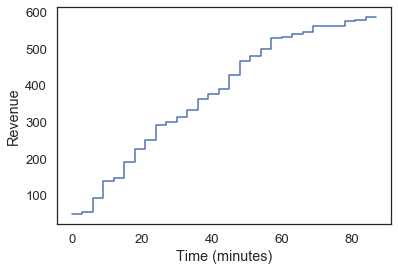

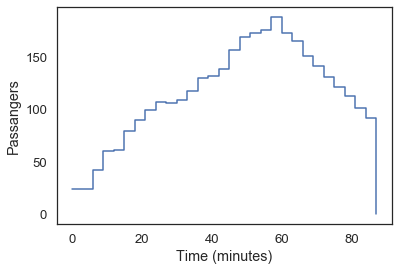

Total revenue was 588.00
Total trip time was 87.00 minutes


In [294]:
import matplotlib.pyplot as plt

plt.figure()
plt.step(obs_time, obs_revenue, where='post')
plt.xlabel('Time (minutes)')
plt.ylabel('Revenue')

plt.figure()
plt.step(obs_time, obs_passangers, where='post')
plt.xlabel('Time (minutes)')
plt.ylabel('Passangers')

plt.show()

print('Total revenue was {:.2f}'.format(obs_revenue[-1]))
print('Total trip time was {:.2f} minutes'.format(obs_time[-1]))

**Revenue generated:**

The first graphs also show revenue growth which is faster at the initial stages since the bus can pick every passanger waiting at the bus stops, later and as the bus runs at full capacity the number of passangers is only equivalent to the number of pasangers that alight unless the number of passangers at the metro stop is less than those that alight. this leads to less revenues and lost revenues since some of the passangers left along the way might find other means of travel for the day or if this keeps happening they might find a more permanent alternative means of travel.

**Passanger flow:**

The second graph represents the net number of passangers (initial passangers - onboarding - alighted) along the metro route. This is a confirmation of the conclusion above where we see the metro bus running at full capacity a few minutes after departing Avondale for Farragut North. 

Be sure that your code works!

The code runs without errors.